In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import torch
from tqdm.auto import tqdm

import maze
import env_utils
from functools import partial
import goexplore_discrete
from torch import nn
from mzr_old import layer_init

In [3]:
import wandb
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akarshkumar0101 (use `wandb login --relogin` to force relogin)


In [7]:
from maze_run import make_single_env, make_env

In [4]:
import maze_run

In [5]:
import maze_something

In [8]:
ges = torch.load('data/ges.pt')

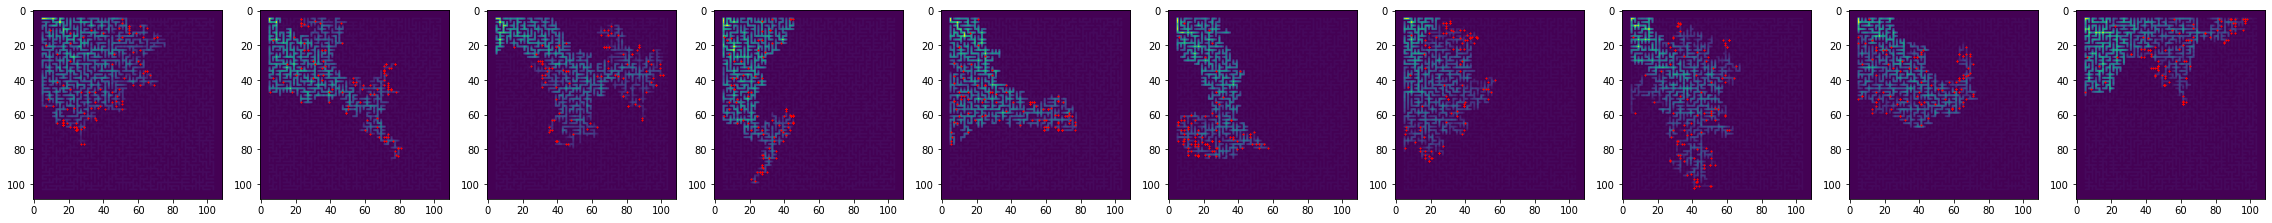

In [11]:
fig = maze_something.viz_ge_node_selection(ges)

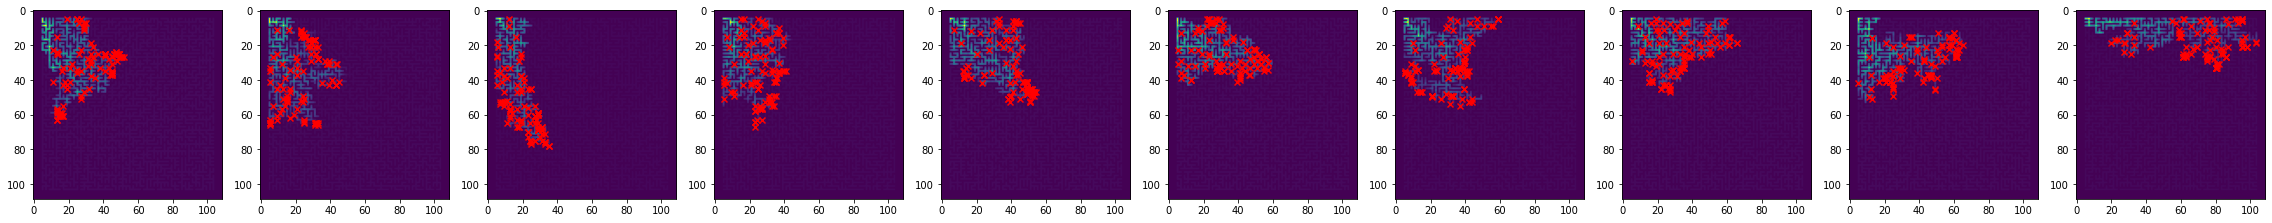

In [167]:
plt.figure(figsize=(40, 5))
for i_plt, ge in enumerate(ges[:10]):
    grid = ge.env.envs[0].maze.copy()
    cells = list(ge.cell2n_seen.keys())
    n_seen = list(ge.cell2n_seen.values())
    for i in range(len(cells)):
        y, x = cells[i]
        grid[y, x] = n_seen[i]
    plt.subplot(1, 10, i_plt+1)
    plt.imshow(grid)
    nodes = ge.select_nodes(100, beta=-2.0, condition=lambda node: len(node.snapshot)>10)
    # nodes = ge.select_nodes(100, beta=-0.5, condition=lambda node: len(node.snapshot)>10)
    cells = np.array([node.cell for node in nodes])
    plt.scatter(cells[:, 1], cells[:, 0], marker='x', c='r')

In [168]:
def create_bc_dataset(ges, n_nodes=10, n_samples_per_node=10, beta=-2.0):
    x, y = [], []
    for ge in tqdm(ges):
        env = ge.env.envs[0]

        nodes = ge.select_nodes(n_nodes, beta=beta, condition=lambda node: len(node.snapshot)>n_samples_per_node)
        for node in nodes:
            x_node, y_node = [], []
            obs, info = env.reset()
            for action in node.snapshot:
                x_node.append(obs)
                y_node.append(action)
                obs, reward, terminated, truncated, info = env.step(action)
            idx_traj = np.random.randint(0, len(x_node), size=n_samples_per_node)
            x.extend([x_node[i] for i in idx_traj])
            y.extend([y_node[i] for i in idx_traj])
    x, y = np.stack(x), np.asarray(y)
    x, y = torch.as_tensor(x).float(), torch.as_tensor(y).long()
    return x, y
x_train, y_train = create_bc_dataset(ges, 100, 10)
print(x_train.shape, y_train.shape)

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


torch.Size([100000, 4, 11, 11]) torch.Size([100000])


In [169]:
class RandomExplorer(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.n_actions = envs.single_action_space.n
    def forward(self, x):
        return self.get_dist_and_values(x)
    def get_dist_and_values(self, x):
        logits = torch.zeros(x.shape[0], self.n_actions, device=x.device)
        values = torch.zeros(x.shape[0], 1, device=x.device)
        dist = torch.distributions.Categorical(logits=logits)
        return dist, values[:, 0]
    def act(self, x):
        dist, _ = self.get_dist_and_values(x)
        return dist.sample()

class ImitationExplorer(nn.Module):
    def __init__(self, envs, num_frames=4):
        super().__init__()
        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(num_frames, 16, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(16, 32, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 3 * 3, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)
    def forward(self, x):
        return self.get_dist_and_values(x)

    def get_dist_and_values(self, x):
        x = self.encoder(x)
        logits, values = self.actor(x), self.critic(x)
        dist = torch.distributions.Categorical(logits=logits)
        return dist, values[:, 0]

    def act(self, x):
        dist, _ = self.get_dist_and_values(x)
        return dist.sample()

In [170]:
def train_bc_agent(agent, x_train, y_train, batch_size=32, n_batches=10, lr=1e-3, coef_entropy=0.0, device=None, tqdm=None):
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    opt = torch.optim.Adam(agent.parameters(), lr=lr)
    pbar = range(n_batches)
    if tqdm is not None:
        pbar = tqdm(pbar)
    for i_batch in pbar:
        idxs_batch = torch.randperm(len(x_train))[:batch_size]
        x_batch, y_batch = x_train[idxs_batch].float().to(device), y_train[idxs_batch].long().to(device)
        dist, values = agent.get_dist_and_values(x_batch)

        loss_bc = loss_fn(dist.logits, y_batch).mean()
        loss_entropy = dist.entropy().mean()
        loss = loss_bc - coef_entropy * loss_entropy
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.set_postfix(loss_bc=loss_bc.item(), entropy=loss_entropy.item())

In [195]:
agent_random = RandomExplorer(ge.env)

In [171]:
agent = ImitationExplorer(ge.env)
train_bc_agent(agent, x_train, y_train, batch_size=512, n_batches=10000, tqdm=tqdm)

100%|██████████| 10000/10000 [07:09<00:00, 23.30it/s, entropy=0.109, loss_bc=0.129] 


In [172]:
mazes_test = torch.load('data/mazes_test.pt')

In [298]:
def get_state_coverage(agent=None):
    cells = [set() for maze in mazes_test]
    statecov = [[] for maze in mazes_test]
    for i_maze, maze in enumerate(tqdm(mazes_test)):
        env = maze_run.make_env(1, maze=maze, obs_size=5, frame_stack=4)
        obs, info = env.reset()
        for i_trans in range(1000):
            cells[i_maze].add(info['cell'][0])
            statecov[i_maze].append(len(cells[i_maze]))
            obs, reward, terminated, truncated, info = env.step(agent.act(obs))
    statecov = np.array(statecov)
    return statecov

statecov_random = get_state_coverage(agent_random) 
statecov_agent = get_state_coverage(agent) 

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


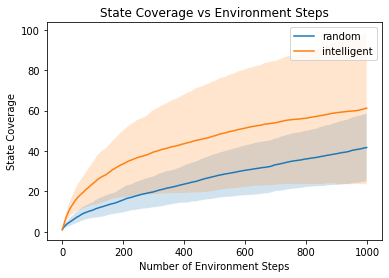

In [304]:
mean = statecov_random.mean(axis=0)
std = statecov_random.std(axis=0)
plt.plot(mean, label='random')
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)

mean = statecov_agent.mean(axis=0)
std = statecov_agent.std(axis=0)
plt.plot(mean, label='intelligent')
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)
plt.title('State Coverage vs Environment Steps')
plt.ylabel('State Coverage')
plt.xlabel('Number of Environment Steps')
plt.legend()
plt.show()

In [208]:
import cv2

In [293]:
def get_video(agent, maze):
    video = []
    env = maze_run.make_env(1, maze=maze, obs_size=5, frame_stack=4)
    maze_full = env.envs[0].maze
    obs, info = env.reset()
    for i_trans in tqdm(range(1000)):
        y, x = info['cell'][0]
        left = obs[0, -1].cpu().numpy()
        left = (left+1).clip(0, 1)*255
        right = ((maze_full.copy()+1)*255).astype(np.uint8)
        left = np.stack((left,)*3, axis=-1)
        left[len(left)//2, len(left)//2] = [255, 0, 0]
        left = cv2.resize(left, right.shape, interpolation=cv2.INTER_NEAREST)
        right = np.stack((right,)*3, axis=-1)
        right[y, x] = [255, 0, 0]
        video.append(np.hstack([left, right]))
        # video.append(left)
        obs, reward, terminated, truncated, info = env.step(agent.act(obs))
    video = np.stack(video)
    return video

In [295]:
for maze in mazes_test[:10]:
    video_random = get_video(agent_random, maze)
    video_agent = get_video(agent, maze)
    wandb.log({
        'video_random': wandb.Video(video_random.transpose(0, 3, 1, 2), fps=4),
        'video_agent': wandb.Video(video_agent.transpose(0, 3, 1, 2), fps=4)
    })

100%|██████████| 1000/1000 [00:01<00:00, 745.10it/s]


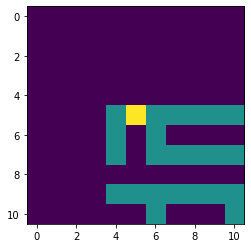

In [202]:
plt.imshow(video_a[-1])

In [137]:
np.random.seed(10032)
grid = maze.generate_maze(71, 71)
env_eval = maze_run.make_env(grid[None], 1, 4)

In [168]:
video = []
obs, info = env_eval.reset()
for i in tqdm(range(100)):
    video.append(obs[-1])
    obs, reward, terminated, truncated, info = env_eval.step(agent.act(obs))
video = np.concatenate(video, axis=0)

100%|██████████| 100/100 [00:00<00:00, 897.57it/s]


0


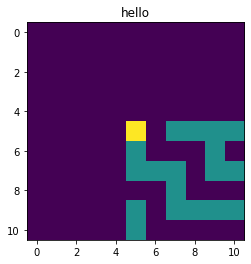

40


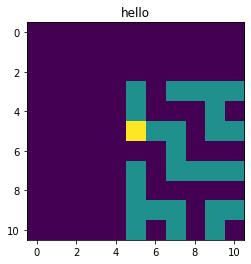

80


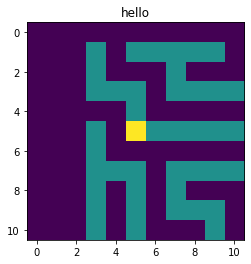

120


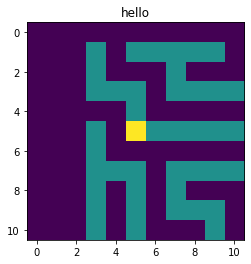

160


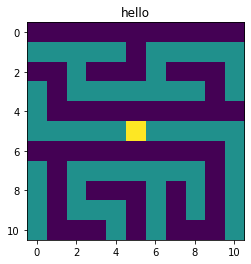

200


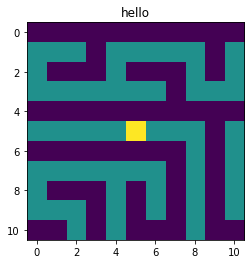

240


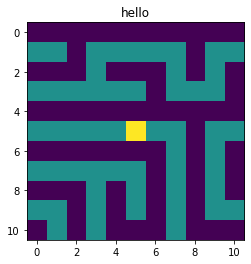

280


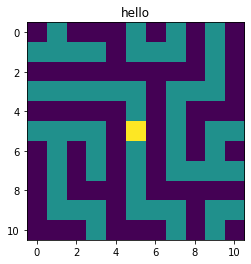

320


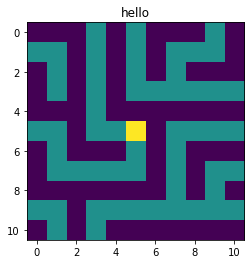

360


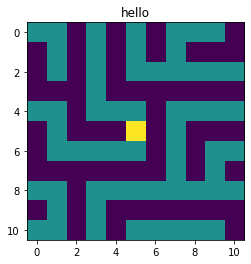

In [171]:
for i in range(0, len(video), 40):
    print(i)
    plt.imshow(video[i])
    plt.show()